
このノートブックを実行するには、次の追加ライブラリが必要です。 Colab での実行は実験的なものであることに注意してください。問題がある場合は、Github の問題を報告してください。


In [ ]:
!pip install d2l==1.0.0-beta0



# アテンションスコアリング関数

:label: `sec_attention-scoring-functions`

 :numref: `sec_attention-pooling`では、クエリとキー間の相互作用をモデル化するガウス カーネルを含む、さまざまな距離ベースのカーネルを使用しました。結局のところ、距離関数は内積よりも計算コストがわずかに高くなります。そのため、非負の注意重みを保証するためのソフトマックス演算では、計算がより簡単な :eqref: `eq_softmax_attention`および :numref: `fig_attention_output`*の注意スコアリング関数*$a$ に作業の多くが費やされました。 

![](../img/attention-output.svg) :label: `fig_attention_output`


In [1]:
import math
import torch
from torch import nn
from d2l import torch as d2l


## [**内積アテンション**]

ガウス カーネルのアテンション関数 (べき乗なし) を少し見てみましょう。

 $$ \begin{aligned} a(\mathbf{q}, \mathbf{k}_i) &amp; = -\frac{1}{2} |\mathbf{q} - \mathbf{k}_i|^2 \ &amp; = \mathbf{q}^\top \mathbf{k}_i -\frac{1}{2} |\mathbf{k}_i|^2 -\frac{1}{2} |\mathbf{q} |^2。 \end{整列} $$

まず、最後の項は $\mathbf{q}$ のみに依存することに注意してください。したがって、これはすべての $(\mathbf{q}, \mathbf{k}_i)$ ペアで同一です。 :eqref: `eq_softmax_attention`で行われるように、アテンションの重みを $1$ に正規化すると、この用語が完全に消えます。第二に、バッチ正規化と層正規化 (後で説明します) の両方が、境界が明確で、多くの場合一定のノルムを持つ活性化につながることに注意してください $|\mathbf{k}_i| \約\mathrm{const}$。これは、たとえば、キー $\mathbf{k}_i$ が層ノルムによって生成された場合に当てはまります。そのため、結果に大きな変更を加えることなく $a$ の定義から削除できます。

最後に、指数関数の引数の大きさの順序を制御する必要があります。クエリ $\mathbf{q} \in \mathbb{R}^d$ とキー $\mathbf{k}_i \in \mathbb{R}^d$ のすべての要素が独立しており、同様にランダムに描画されると仮定します。ゼロ平均と単位分散を持つ変数。両方のベクトル間のドット積の平均はゼロ、分散は $d$ です。ベクトルの長さに関係なく内積の分散が 1 のままであることを保証するために、*スケーリングされた内積注意*スコア関数を使用します。つまり、内積を $1/\sqrt{d}$ で再スケーリングします。したがって、たとえばトランスフォーマーで使用される最初の一般的に使用されるアテンション関数に到達します:cite: `Vaswani.Shazeer.Parmar.ea.2017` :

 $$ a(\mathbf{q}, \mathbf{k}_i) = \mathbf{q}^\top \mathbf{k}_i / \sqrt{d}.$$ :eqlabel: `eq_dot_product_attention`

注意の重み $\alpha$ はまだ正規化する必要があることに注意してください。これは、softmax 演算を使用する :eqref: `eq_softmax_attention`によってさらに簡素化できます。

 *$$\alpha(\mathbf{q}, \mathbf{k} i) = \mathrm{softmax}(a(\mathbf{q}, \mathbf{k}_i)) = \frac{\exp(\mathbf {q}^\top \mathbf{k}_i / \sqrt{d})}{\sum* {j=1} \exp(\mathbf{q}^\top \mathbf{k}_j / \sqrt{d })}.$$ :eqlabel: `eq_attn-scoring-alpha`

結局のところ、一般的なアテンション メカニズムはすべてソフトマックスを使用しているため、この章の残りの部分ではソフトマックスに限定して説明します。

## 便利な機能

アテンション メカニズムを効率的に展開するには、いくつかの関数が必要です。これには、可変長の文字列を処理するツール (自然言語処理に一般的) と、ミニバッチで効率的に評価するツール (バッチ行列乗算) が含まれます。

###  [**マスクされたソフトマックス操作**]

アテンション メカニズムの最も一般的なアプリケーションの 1 つは、モデルをシーケンスすることです。したがって、異なる長さのシーケンスを処理できる必要があります。場合によっては、そのようなシーケンスが同じミニバッチ内に収まることがあり、短いシーケンスの場合はダミー トークンでパディングする必要があります (例については、:numref: `sec_machine_translation`を参照)。これらの特別なトークンには意味がありません。たとえば、次の 3 つの文があるとします。

アテンション モデルに空白は必要ないので、 $\sum_{i=1}^n \alpha(\mathbf{q}, \mathbf{k} *i) \mathbf{v}_i$ を $ に*制限するだけです。 *\sum* {i=1}^l \alpha(\mathbf{q}, \mathbf{k}_i) \mathbf{v}_i$ は、実際の文の長さ $l \leq n$ に関係なく。これは非常に一般的な問題であるため、 *「マスクされたソフトマックス操作」*という名前が付けられています。

実装しましょう。実際、実装は、$i &gt; l$ の場合、値をゼロ $\mathbf{v}_i = 0$ に設定することで、わずかに不正行為を行っています。さらに、注意の重みを $-10^{6}$ などの大きな負の数に設定して、実際には勾配と値への寄与がなくなるようにします。これが行われるのは、線形代数カーネルと演算子が GPU 向けに大幅に最適化されており、条件付き (if then else) ステートメントを含むコードを使用するよりも、計算に多少の無駄を省いた方が高速であるためです。


In [2]:
def masked_softmax(X, valid_lens):  #@save
    """Perform softmax operation by masking elements on the last axis."""
    # X: 3D tensor, valid_lens: 1D or 2D tensor
    def _sequence_mask(X, valid_len, value=0):
        maxlen = X.size(1)
        mask = torch.arange((maxlen), dtype=torch.float32,
                            device=X.device)[None, :] < valid_len[:, None]
        X[~mask] = value
        return X

    if valid_lens is None:
        return nn.functional.softmax(X, dim=-1)
    else:
        shape = X.shape
        if valid_lens.dim() == 1:
            valid_lens = torch.repeat_interleave(valid_lens, shape[1])
        else:
            valid_lens = valid_lens.reshape(-1)
        # On the last axis, replace masked elements with a very large negative
        # value, whose exponentiation outputs 0
        X = _sequence_mask(X.reshape(-1, shape[-1]), valid_lens, value=-1e6)
        return nn.functional.softmax(X.reshape(shape), dim=-1)


[**この関数がどのように機能するかを説明する**]ために、サイズ $2 \times 4$ の 2 つの例のミニバッチを考えます。有効な長さはそれぞれ $2$ と $3$ です。マスクされたソフトマックス操作の結果、ベクトルの各ペアの有効な長さを超える値はすべてゼロとしてマスクされます。


In [3]:
masked_softmax(torch.rand(2, 2, 4), torch.tensor([2, 3]))

tensor([[[0.5773, 0.4227, 0.0000, 0.0000],
         [0.5674, 0.4326, 0.0000, 0.0000]],

        [[0.5241, 0.2477, 0.2282, 0.0000],
         [0.3224, 0.2454, 0.4322, 0.0000]]])


例ごとに 2 つのベクトルのそれぞれの有効な長さを指定するためのより詳細な制御が必要な場合は、単純に有効な長さの 2 次元テンソルを使用します。これにより、次の結果が得られます。


In [4]:
masked_softmax(torch.rand(2, 2, 4), torch.tensor([[1, 3], [2, 4]]))

tensor([[[1.0000, 0.0000, 0.0000, 0.0000],
         [0.4743, 0.3170, 0.2087, 0.0000]],

        [[0.4712, 0.5288, 0.0000, 0.0000],
         [0.2280, 0.2086, 0.2058, 0.3576]]])


### バッチ行列乗算

:label: `subsec_batch_dot`

もう 1 つの一般的に使用される操作は、行列のバッチを別の行列と乗算することです。これは、クエリ、キー、値のミニバッチがある場合に便利です。より具体的には、次のように仮定します

$$\mathbf{Q} = [\mathbf{Q}_1, \mathbf{Q}_2, \ldots, \mathbf{Q}_n] \in \mathbb{R}^{n \times a \times b} \ \mathbf{K} = [\mathbf{K}_1, \mathbf{K}_2, \ldots, \mathbf{K}_n] \in \mathbb{R}^{n \times b \times c} $ $

次に、バッチ行列乗算 (BMM) が要素ごとの積を計算します。

 $$\mathrm{BMM}(\mathbf{Q}, \mathbf{K}) = [\mathbf{Q}_1 \mathbf{K}_1, \mathbf{Q}_2 \mathbf{K}_2, \ldots , \mathbf{Q}_n \mathbf{K}_n] \in \mathbb{R}^{n \times a \times c}.$$ :eqlabel: `eq_batch-matrix-mul`

これを深層学習フレームワークで実際に見てみましょう。


In [5]:
Q = torch.ones((2, 3, 4))
K = torch.ones((2, 4, 6))
d2l.check_shape(torch.bmm(Q, K), (2, 3, 6))


## [**スケーリングされた内積アテンション**]

 :eqref: `eq_dot_product_attention`で紹介されたドット積アテンションに戻りましょう。一般に、クエリとキーの両方が同じベクトル長、たとえば $d$ である必要がありますが、これは $\mathbf{q}^\top \mathbf{k}$ を $\ に置き換えることで簡単に対処できます。 mathbf{q}^\top \mathbf{M} \mathbf{k}$ ここで、$\mathbf{M}$ は、両方の空間間で変換するために適切に選択された行列です。ここでは、寸法が一致していると仮定します。

実際には、$n$ クエリや $m$ のキーと値のペア (クエリとキーの長さは $d$、値の長さは $v$ です) に対するアテンションの計算など、効率性を高めるためにミニバッチで考えることがよくあります。クエリ $\mathbf Q\in\mathbb R^{n\times d}$、キー $\mathbf K\in\mathbb R^{m\times d}$、および値 $\mathbf のスケーリングされたドット積アテンションしたがって、V\in\mathbb R^{m\times v}$ は次のように書くことができます。

 $$ \mathrm{softmax}\left(\frac{\mathbf Q \mathbf K^\top }{\sqrt{d}}\right) \mathbf V \in \mathbb{R}^{n\times v} .$$ :eqlabel: `eq_softmax_QK_V`

これをミニバッチに適用する場合、 :eqref: `eq_batch-matrix-mul`で導入されたバッチ行列乗算が必要になることに注意してください。スケーリングされたドット積アテンションの次の実装では、モデルの正則化にドロップアウトを使用します。


In [6]:
class DotProductAttention(nn.Module):  #@save
    """Scaled dot product attention."""
    def __init__(self, dropout):
        super().__init__()
        self.dropout = nn.Dropout(dropout)

    # Shape of queries: (batch_size, no. of queries, d)
    # Shape of keys: (batch_size, no. of key-value pairs, d)
    # Shape of values: (batch_size, no. of key-value pairs, value dimension)
    # Shape of valid_lens: (batch_size,) or (batch_size, no. of queries)
    def forward(self, queries, keys, values, valid_lens=None):
        d = queries.shape[-1]
        # Swap the last two dimensions of keys with keys.transpose(1, 2)
        scores = torch.bmm(queries, keys.transpose(1, 2)) / math.sqrt(d)
        self.attention_weights = masked_softmax(scores, valid_lens)
        return torch.bmm(self.dropout(self.attention_weights), values)


[ **`DotProductAttention`クラスがどのように機能するかを説明する**]ために、付加的な注意のために、前のおもちゃの例と同じキー、値、有効な長さを使用します。この例では、ミニバッチ サイズが $2$、キーと値の合計が $10$、値の次元が $4$ であると仮定します。最後に、観測ごとの有効な長さはそれぞれ $2$ と $6$ であると仮定します。それを考慮すると、出力は $2 \times 1 \times 4$ テンソル、つまりミニバッチの例ごとに 1 行になることが予想されます。


In [7]:
queries = torch.normal(0, 1, (2, 1, 2))
keys = torch.normal(0, 1, (2, 10, 2))
values = torch.normal(0, 1, (2, 10, 4))
valid_lens = torch.tensor([2, 6])

attention = DotProductAttention(dropout=0.5)
attention.eval()
d2l.check_shape(attention(queries, keys, values, valid_lens), (2, 1, 4))


それぞれ 2 列目と 6 列目以降のアテンションの重みが実際に消えるかどうかを確認してみましょう (有効な長さを $2$ と $6$ に設定しているため)。


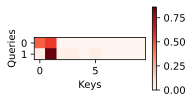

In [8]:
d2l.show_heatmaps(attention.attention_weights.reshape((1, 1, 2, 10)),
                  xlabel='Keys', ylabel='Queries')


## 【**添加物注意**】

 :label: `subsec_additive-attention`

クエリ $\mathbf{q}$ とキー $\mathbf{k}$ が異なる次元のベクトルである場合、 $\mathbf{q}^\top \mathbf{M} \ を介して行列を使用して不一致に対処できます。 mathbf{k}$ を使用するか、得点関数として加算的注意を使用することもできます。もう 1 つの利点は、その名前が示すように、注意が付加的であることです。これにより、若干の計算量の節約につながる可能性があります。クエリ $\mathbf{q} \in \mathbb{R}^q$ とキー $\mathbf{k} \in \mathbb{R}^k$ が与えられると、*加法的注意*スコアリング関数 :cite: `Bahdanau.Cho.Bengio.2014`は次によって与えられます。

 $$a(\mathbf q, \mathbf k) = \mathbf w_v^\top \text{tanh}(\mathbf W_q\mathbf q + \mathbf W_k \mathbf k) \in \mathbb{R},$$ : eqlabel: `eq_additive-attn`

ここで、$\mathbf W_q\in\mathbb R^{h\times q}$、$\mathbf W_k\in\mathbb R^{h\times k}$、および $\mathbf w_v\in\mathbb R^{h }$ は学習可能なパラメータです。次に、この項はソフトマックスに入力されて、非負性と正規化の両方が保証されます。 :eqref: `eq_additive-attn`の同等の解釈は、クエリとキーが連結され、単一の隠れ層を持つ MLP に供給されることです。 $\tanh$ を活性化関数として使用し、バイアス項を無効にして、次のように追加の注意を実装します。


In [9]:
class AdditiveAttention(nn.Module):  #@save
    """Additive attention."""
    def __init__(self, num_hiddens, dropout, **kwargs):
        super(AdditiveAttention, self).__init__(**kwargs)
        self.W_k = nn.LazyLinear(num_hiddens, bias=False)
        self.W_q = nn.LazyLinear(num_hiddens, bias=False)
        self.w_v = nn.LazyLinear(1, bias=False)
        self.dropout = nn.Dropout(dropout)

    def forward(self, queries, keys, values, valid_lens):
        queries, keys = self.W_q(queries), self.W_k(keys)
        # After dimension expansion, shape of queries: (batch_size, no. of
        # queries, 1, num_hiddens) and shape of keys: (batch_size, 1, no. of
        # key-value pairs, num_hiddens). Sum them up with broadcasting
        features = queries.unsqueeze(2) + keys.unsqueeze(1)
        features = torch.tanh(features)
        # There is only one output of self.w_v, so we remove the last
        # one-dimensional entry from the shape. Shape of scores: (batch_size,
        # no. of queries, no. of key-value pairs)
        scores = self.w_v(features).squeeze(-1)
        self.attention_weights = masked_softmax(scores, valid_lens)
        # Shape of values: (batch_size, no. of key-value pairs, value
        # dimension)
        return torch.bmm(self.dropout(self.attention_weights), values)


[ **`AdditiveAttention`どのように機能するか見てみ**ましょう]。このおもちゃの例では、サイズがそれぞれ $(2, 1, 20)$、$(2, 10, 2)$、$(2, 10, 4)$ のクエリ、キー、値を選択します。これは、クエリが $20$ 次元になることを除いて、 `DotProductAttention`の選択と同じです。同様に、ミニバッチ内のシーケンスの有効な長さとして $(2, 6)$ を選択します。


In [10]:
queries = torch.normal(0, 1, (2, 1, 20))

attention = AdditiveAttention(num_hiddens=8, dropout=0.1)
attention.eval()
d2l.check_shape(attention(queries, keys, values, valid_lens), (2, 1, 4))


アテンション関数を確認すると、 `DotProductAttention`の動作と定性的によく似た動作が見られます。つまり、選択された有効な長さ $(2, 6)$ 内の項のみが非ゼロになります。


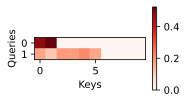

In [11]:
d2l.show_heatmaps(attention.attention_weights.reshape((1, 1, 2, 10)),
                  xlabel='Keys', ylabel='Queries')


## まとめ

このセクションでは、ドット積と加法的注意という 2 つの重要な注意スコアリング関数を紹介しました。これらは、可変長のシーケンス全体を集約するための効果的なツールです。特に、ドット積の注意は、最新の Transformer アーキテクチャの主流です。クエリとキーが異なる長さのベクトルである場合、代わりに加算的注意スコアリング関数を使用できます。これらのレイヤーの最適化は、近年の進歩の重要な分野の 1 つです。たとえば、 [Nvidia の Transformer Library](https://docs.nvidia.com/deeplearning/transformer-engine/user-guide/index.html)と Megatron :cite: `shoeybi2019megatron` 、アテンション メカニズムの効率的なバリアントに決定的に依存しています。後のセクションでトランスフォーマーをレビューするときに、これについてさらに詳しく説明します。

## 演習
1. `DotProductAttention`コードを変更して、距離ベースのアテンションを実装します。効率的な実装には、キー $|\mathbf{k}_i|^2$ の二乗ノルムのみが必要であることに注意してください。
1. 行列を使用して次元を調整することにより、異なる次元のクエリとキーを許可できるようにドット積アテンションを変更します。
1. 計算コストは​​、キー、クエリ、値、およびそれらの数の次元に応じてどのように変化しますか?メモリ帯域幅の要件についてはどうですか?



[ディスカッション](https://discuss.d2l.ai/t/1064)
